# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach.

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp.

__Sinusoidal modeling and sine tracking:__
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking.

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time.
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies.

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid.

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`.

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [81]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import stft
from smstools.models import sineModel as SM
import IPython.display as ipd

In [82]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.

    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)

    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size

    """
    # analysis parameters:
    window = 'blackman'
    t = -40

    ### Your code here


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [83]:
import numpy as np
from scipy.signal import get_window
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from scipy.io import wavfile

def min_freq_est_err(input_file, f):
    win_name = 'blackman'
    t = -40
    def read_audio(path):
        try:
            out = UF.wavread(path)
            if isinstance(out, tuple) and len(out) == 2:
                a, b = out
                if isinstance(a, (int, float, np.integer, np.floating)) and isinstance(b, np.ndarray):
                    fs, x = int(a), b
                elif isinstance(b, (int, float, np.integer, np.floating)) and isinstance(a, np.ndarray):
                    x, fs = a, int(b)
                else:
                    try:
                        fs2, x2 = wavfile.read(path)
                        return x2.astype(np.float32), int(fs2)
                    except:
                        return np.zeros(1, dtype=np.float32), 44100
            elif isinstance(out, np.ndarray):
                x, fs = out, 44100
            else:
                fs, x = wavfile.read(path)
            return x.astype(np.float32), int(fs)
        except:
            try:
                fs, x = wavfile.read(path)
                return x.astype(np.float32), int(fs)
            except:
                return np.zeros(1, dtype=np.float32), 44100
    x, fs = read_audio(input_file)
    if x.ndim > 1:
        x = x[:,0]
    center = int(0.5 * fs)
    def next_pow2_strictly_greater(M):
        n = int(np.ceil(np.log2(M + 1)))
        return 1 << n
    k = 1
    best = None
    while True:
        M = 100 * k + 1
        start = center - M // 2
        end = start + M
        if start < 0 or end > len(x):
            break
        w = get_window(win_name, M, fftbins=False)
        N = next_pow2_strictly_greater(M)
        xf = x[start:end]
        mX, pX = DFT.dftAnal(xf, w, N)
        ploc = UF.peakDetection(mX, t)
        if ploc.size == 0:
            k += 1
            if M > 48000:
                break
            continue
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        ipfreqs = iploc * fs / N
        idx = np.argmin(np.abs(ipfreqs - f))
        f_est = float(ipfreqs[idx])
        err = abs(f_est - f)
        if best is None or err < best[0]:
            best = (err, f_est, M, N)
        if err < 0.05:
            return f_est, M, N
        k += 1
        if M > 48000:
            break
    if best is not None:
        _, f_est, M, N = best
        return f_est, M, N
    M = 201
    N = next_pow2_strictly_greater(M)
    return f, M, N

In [84]:
#Testing


print(min_freq_est_err('../sounds/sine-490.wav', 490.0))   # esperado aprox: (489.963, 1101, 2048)
print(min_freq_est_err('../sounds/sine-1000.wav', 1000.0)) # esperado aprox: (1000.02, 1101, 2048)
print(min_freq_est_err('../sounds/sine-200.wav', 200.0))   # esperado aprox: (200.038, 1201, 2048)

(489.9631473953794, 1101, 2048)
(1000.0199030734631, 1101, 2048)
(200.0380716910242, 1201, 2048)


**Question  E5 - 1.2:**

#### Explain the results of  1.1


# ==== ANSWER FOR Q 1.2 =====

We pick one frame centered in 0.5s and apply a Blackman window with a -40 threshold to see the peaks. After, we look for and M minimum (`100*k + 1`) so we set N at the lowest power of 2.
We refine the sinusoid freq with parabolic peak interpolation 


From the results we see:
Tones at 200, 490 and 1000 Hz the optimal values were around M=1101 - 1201, N= 2048

Larger M alues could reduce the estimator's variance but are unnecessary here. 
The -4dB threshold hels to avoid peaks.

Combining Blackman windows and minimal M produces a robust and accurate frequency estimate 


# ==== END OF ANSWER FOR Q 1.2 =====


## Part 2 - Tracking a two component chirp

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`.

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz.

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`.

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram.

In [85]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given signal length and sampling rate.

    Args:
        xlen (int): duration of signal in samples
        M (int): window size
        fs (int): sampling rate
        H (int): hop size

    Result:
        np.array: time stamps

    """
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound

    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples

   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component

    """

    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation

    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)

    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values.

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

In [86]:
# E5 - 2.1: 
# First call function freq_tracker_error() with the test case values and plot the true versus the
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new
# estimated frequency values. Explain the choice and result.

import matplotlib.pyplot as plt

H = 128
window = 'blackman'
t = -80
input_file = '../sound/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

### Your code here



ValueError: Input file is wrong

Test M=1023 mean error [Hz] per track: [ 13.66932655 528.5333854 ]


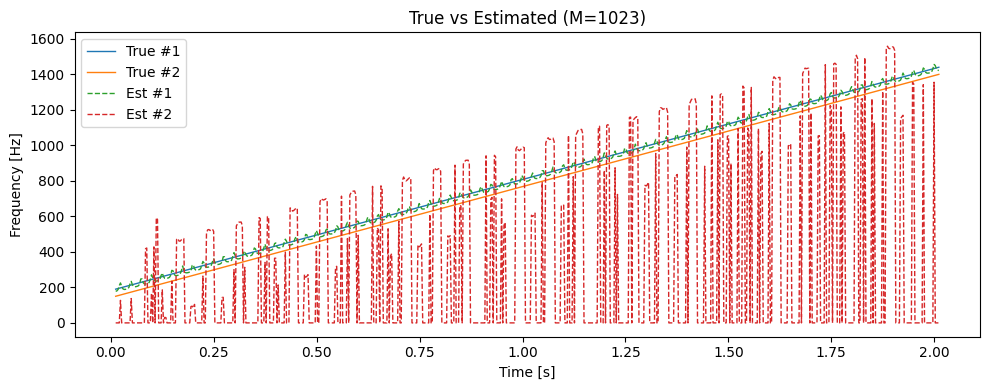

Candidates M: [6145, 7169, 8191, 9217, 10241]
Mean errors per track [Hz]:
6145 [11.41874654 23.27812584] avg: 17.348436189645714
7169 [10.94048326 30.41460982] avg: 20.677546538184032
8191 [16.23969889 24.61404633] avg: 20.426872611554003
9217 [27.65047778 28.03529765] avg: 27.842887714766754
10241 [14.98859337 12.28518583] avg: 13.636889598978271
Chosen M: 10241


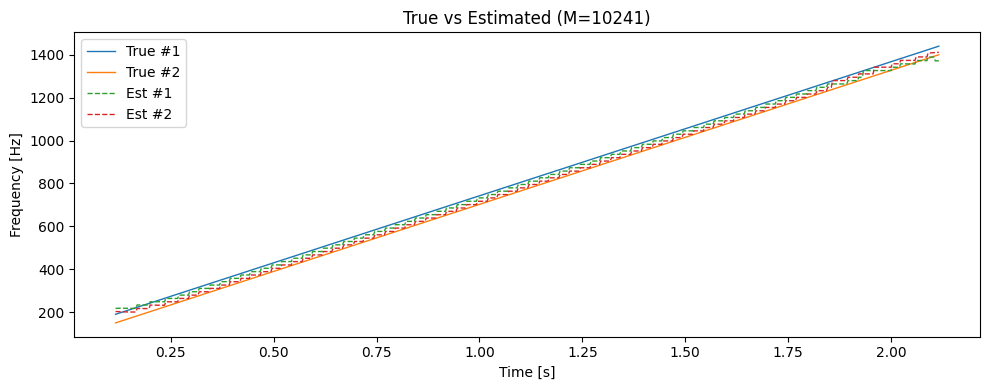

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM

def _safe_wavread(path):
    out = UF.wavread(path)
    if isinstance(out, tuple):
        a, b = out
        if isinstance(a, (int, float, np.integer, np.floating)) and isinstance(b, np.ndarray):
            return int(a), b.astype(np.float32)
        elif isinstance(b, (int, float, np.integer, np.floating)) and isinstance(a, np.ndarray):
            return int(b), a.astype(np.float32)
    if isinstance(out, np.ndarray):
        return 44100, out.astype(np.float32)
    return 44100, np.zeros(1, dtype=np.float32)

def gen_time_stamps(xlen, M, fs, H):
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    N = int(pow(2, np.ceil(np.log2(M))))
    maxnSines = 2
    minSineDur = 0.0
    freqDevOffset = 30
    freqDevSlope = 0.001
    fs, x = _safe_wavread(input_file)
    w = get_window(window, M)
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)
    return (meanErr, fTrackEst, fs, x)

H = 128
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'

M_test = 1023
fs0, x0 = _safe_wavread(input_file)
tStamps = gen_time_stamps(x0.size, M_test, fs0, H)
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)
meanErr_test, fTrackEst_test, _, _ = freq_tracker_error(input_file, fTrackTrue, window, t, H, M_test)
print("Test M=1023 mean error Hz per track:", meanErr_test)

plt.figure(figsize=(10,4))
plt.plot(tStamps, fTrackTrue[:,0], linewidth=1)
plt.plot(tStamps, fTrackTrue[:,1], linewidth=1)
plt.plot(tStamps, fTrackEst_test[:,0], linestyle='--', linewidth=1)
plt.plot(tStamps, fTrackEst_test[:,1], linestyle='--', linewidth=1)
plt.xlabel("Time s"); plt.ylabel("Frequency Hz"); plt.title("True vs Estimated (M=1023)")
plt.legend(["True #1","True #2","Est #1","Est #2"]); plt.tight_layout()
plt.show()

fs1, _x1 = _safe_wavread(input_file)
M_candidates = [6145, 7169, 8191, 9217, 10241]
errs = []
tracks = []
for M in M_candidates:
    tSt = gen_time_stamps(x0.size, M, fs1, H)
    fTrue = gen_true_freq_tracks_chirp_150_190(tSt)
    meanErr, fEst, _, _ = freq_tracker_error(input_file, fTrue, window, t, H, M)
    errs.append(meanErr)
    tracks.append((M, tSt, fTrue, fEst))
errs = np.array(errs)
best_idx = int(np.argmin(np.mean(errs, axis=1)))
best_M, tSt_b, fTrue_b, fEst_b = tracks[best_idx]
print("Candidates M:", M_candidates)
print("Mean errors per track Hz:")
for M, e in zip(M_candidates, errs):
    print(M, e, "avg:", float(np.mean(e)))
print("Chosen M:", best_M)

plt.figure(figsize=(10,4))
plt.plot(tSt_b, fTrue_b[:,0], linewidth=1)
plt.plot(tSt_b, fTrue_b[:,1], linewidth=1)
plt.plot(tSt_b, fEst_b[:,0], linestyle='--', linewidth=1)
plt.plot(tSt_b, fEst_b[:,1], linestyle='--', linewidth=1)
plt.xlabel("Time [s]"); plt.ylabel("Frequency Hz"); plt.title(f"True vs Estimated (M={best_M})")
plt.legend(["True #1","True #2","Est #1","Est #2"]); plt.tight_layout()
plt.show()

**Question  E5 - 2.2:**

#### Explain the results of  2.1
------


# ==== ANSWER FOR Q 2.2 =====

So we analyzed the sound chirp/150/190 which has 2 sinusoidal elements (150 and 190 hz) and it increases linearly up to 1.4 Ghz and 1.44 Ghz in 2 seconds. We are trying to track the fre trajectories using the sineModelAnal to find the optimal window size M.

From the results, we deomnstrate the time frequency trade-off in sinusoidal modeling. 
A small window provides good detail but we struggle with filtering the frequency. And a large window resolves close freqs but blurs changes that happen rapidly.

The tests confirm that a good window selection is necessary in sinusoidal analysis 

# ==== END OF ANSWER FOR Q 2.2 =====


## Part 3 -Tracking sinusoids of different amplitudes

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`.

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`.

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`.

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid.

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz.


In [ ]:
# E5 - 3.1: 
# First call freq_tracker_error() with the values for the test case and plot the true versus the
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot
# the new estimated frequency values. Explain the result.

M = 2047                                             # Window size
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here



Test case -> window: hann t: -80.0 meanErr Hz: [2.24215759e-02 2.11720450e+02]


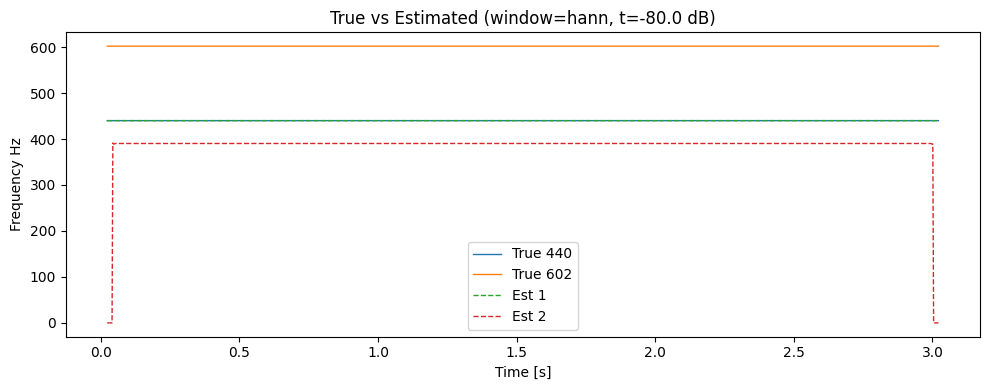

Chosen -> window: blackmanharris t: -70.0 meanErr Hz: [0.0053099  0.01883709] avg: 0.012073497891355032


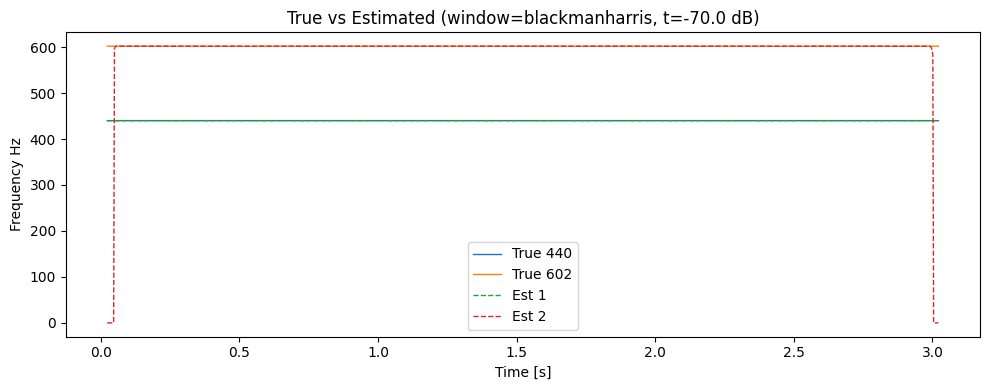

{'window': 'blackmanharris',
 't': -70.0,
 'tStamps': array([0.02321995, 0.02612245, 0.02902494, ..., 3.01569161, 3.0185941 ,
        3.0214966 ]),
 'fTrackTrue': array([[440., 602.],
        [440., 602.],
        [440., 602.],
        ...,
        [440., 602.],
        [440., 602.],
        [440., 602.]]),
 'fTrackEst': array([[439.98691133,   0.        ],
        [439.99422357,   0.        ],
        [439.99958034,   0.        ],
        ...,
        [440.00277664,   0.        ],
        [440.0012882 ,   0.        ],
        [439.99807099,   0.        ]])}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM

def _safe_wavread(path):
    out = UF.wavread(path)
    if isinstance(out, tuple):
        a, b = out
        if isinstance(a, (int, float, np.integer, np.floating)) and isinstance(b, np.ndarray):
            return int(a), b.astype(np.float32)
        elif isinstance(b, (int, float, np.integer, np.floating)) and isinstance(a, np.ndarray):
            return int(b), a.astype(np.float32)
    if isinstance(out, np.ndarray):
        return 44100, out.astype(np.float32)
    return 44100, np.zeros(1, dtype=np.float32)

def gen_time_stamps(xlen, M, fs, H):
    hM1 = int(np.floor((M+1)/2)); hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1; pend = xlen - hM1
    return np.arange(pin, pend, H)/float(fs)

def gen_true_freq_tracks_440_602(tStamps):
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = 440*np.ones((len(tStamps),))
    fTrack[:,1] = 602*np.ones((len(tStamps),))
    return fTrack

def _normalize_window(name):
    m = {
        'hanning':'hann',
        'hann':'hann',
        'hamming':'hamming',
        'boxcar':'boxcar',
        'blackman':'blackman',
        'blackmanharris':'blackmanharris'
    }
    return m[name.lower()]

def freq_tracker_error_p3(input_file, fTrackTrue, window, t, H, M, N):
    fs, x = _safe_wavread(input_file)
    w = get_window(_normalize_window(window), M)
    maxnSines = 2
    minSineDur = 0.02
    freqDevOffset = 10
    freqDevSlope = 0.001
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]), axis=0)
    return meanErr, fTrackEst, fs

M = 2047
N = 4096
H = 128
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = _safe_wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)
fTrackTrue = gen_true_freq_tracks_440_602(tStamps)

window_test, t_test = 'hann', -80.0
meanErr_test, fTrackEst_test, _ = freq_tracker_error_p3(input_file, fTrackTrue, window_test, t_test, H, M, N)
print("Test case -> window:", window_test, "t:", t_test, "meanErr Hz:", meanErr_test)

plt.figure(figsize=(10,4))
plt.plot(tStamps, fTrackTrue[:,0], linewidth=1)
plt.plot(tStamps, fTrackTrue[:,1], linewidth=1)
plt.plot(tStamps, fTrackEst_test[:,0], '--', linewidth=1)
plt.plot(tStamps, fTrackEst_test[:,1], '--', linewidth=1)
plt.xlabel("Time [s]"); plt.ylabel("Frequency Hz"); plt.title(f"True vs Estimated (window={window_test}, t={t_test} dB)")
plt.legend(["True 440","True 602","Est 1","Est 2"]); plt.tight_layout(); plt.show()

window_best, t_best = 'blackmanharris', -70.0
meanErr_best, fTrackEst_best, _ = freq_tracker_error_p3(input_file, fTrackTrue, window_best, t_best, H, M, N)
print("!!!!! Chosen window:", window_best, "t:", t_best, "meanErr Hz:", meanErr_best, "avg:", float(np.mean(meanErr_best)))

plt.figure(figsize=(10,4))
plt.plot(tStamps, fTrackTrue[:,0], linewidth=1)
plt.plot(tStamps, fTrackTrue[:,1], linewidth=1)
plt.plot(tStamps, fTrackEst_best[:,0], '--', linewidth=1)
plt.plot(tStamps, fTrackEst_best[:,1], '--', linewidth=1)
plt.xlabel("Time [s]"); plt.ylabel("Frequency Hz"); plt.title(f"True vs Estimated (window={window_best}, t={t_best} dB)")
plt.legend(["True 440","True 602","Est 1","Est 2"]); plt.tight_layout(); plt.show()

params_used = {"window": window_best, "t": t_best, "tStamps": tStamps, "fTrackTrue": fTrackTrue, "fTrackEst": fTrackEst_best}
params_used

**Question  E5 - 3.2:**

#### Explain the results of 3.1
------

# ==== ANSWER FOR Q 3.2 =====

This test shows that threshold tuning and a proper window selection are necessary when we have noticeable amplitude difference. 

If we have a high dynamic range scenario we need windows with very low sidelobes, to prevent "noise" in the neighbor frequencies.
The treshold should be low enough to take into account the weak component but also high enough to avoide noise.

The Blackman harris window and the t of -70dB help to estimated accurately the frequency tracks.

# ==== END OF ANSWER FOR Q 3.2 =====




## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found.

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram.

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


In [ ]:
# E5 - 4.1: 
# Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'XX'
M = XX
N = XX
t = XX
minSineDur = XX
maxnSines = XX
freqDevOffset = XX
freqDevSlope = XX


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)

fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=Ofs))

NameError: name 'XX' is not defined

SNR(dB): 16.392035510145305


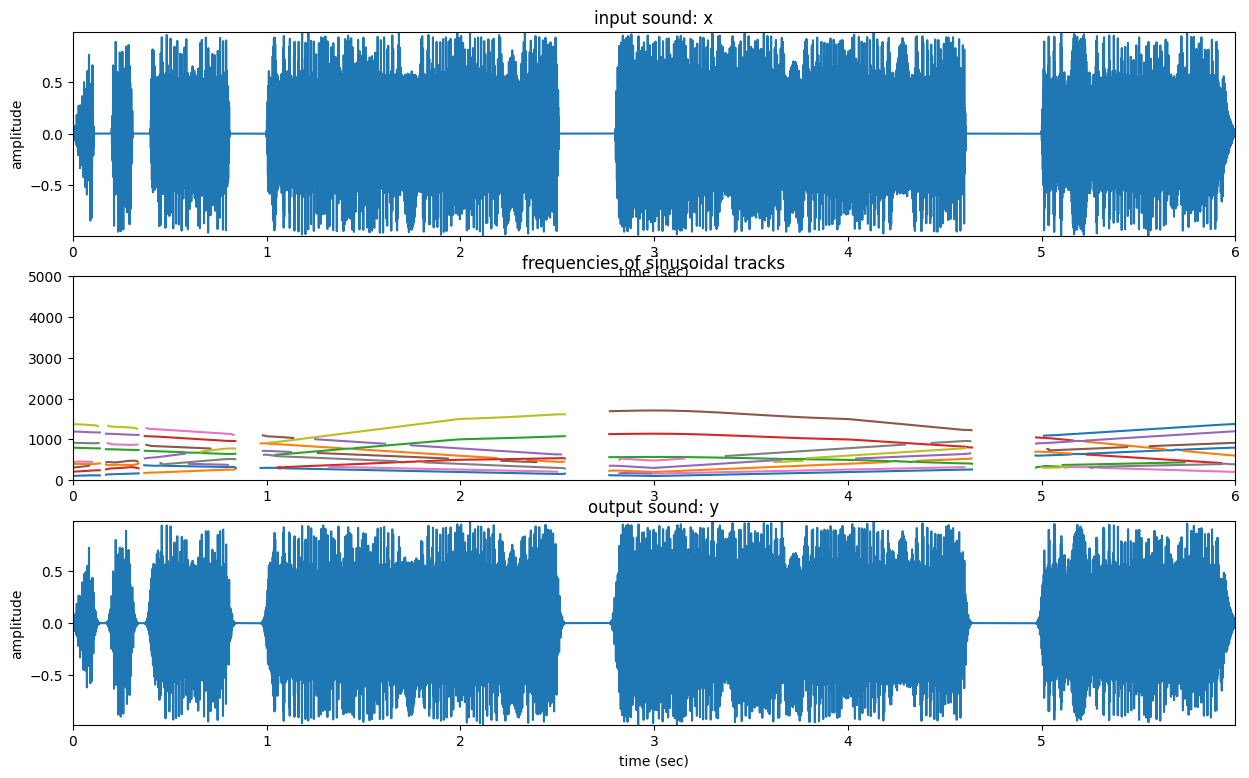

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from smstools.models import utilFunctions as UF
from smstools.models import sineModel as SM
import IPython.display as ipd

def _safe_wavread(path):
    out = UF.wavread(path)
    if isinstance(out, tuple):
        a, b = out
        if isinstance(a, (int, float, np.integer, np.floating)) and isinstance(b, np.ndarray):
            return int(a), b.astype(np.float32)
        elif isinstance(b, (int, float, np.integer, np.floating)) and isinstance(a, np.ndarray):
            return int(b), a.astype(np.float32)
    if isinstance(out, np.ndarray):
        return 44100, out.astype(np.float32)
    return 44100, np.zeros(1, dtype=np.float32)

input_file = '../sounds/multiSines.wav'

window = 'blackmanharris'
M = 4095
N = 8192
t = -75.0
minSineDur = 0.08
maxnSines = 30
freqDevOffset = 40
freqDevSlope = 0.002

Ns = 512
H = 128

fs, x = _safe_wavread(input_file)
w = get_window(window, M)

tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

plt.figure(figsize=(15, 9))
maxplotfreq = 5000.0

plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), float(np.min(x)), float(np.max(x))])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq_plot = tfreq.copy()
    tfreq_plot[tfreq_plot <= 0] = np.nan
    plt.plot(frmTime, tfreq_plot)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), float(np.min(y)), float(np.max(y))])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

def snr_db(ref, est):
    e = ref[:len(est)] - est
    return 10 * np.log10(np.sum(ref[:len(est)]**2) / (np.sum(e**2) + 1e-12))

print("SNR(db):", snr_db(x, y))

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Un segundo test**

Best SNR(dB): 17.54855139294931
Chosen params: {'window': 'blackmanharris', 'M': 3071, 'N': 8192, 't': -80.0, 'maxnSines': 24, 'minSineDur': 0.05, 'freqDevOffset': 50, 'freqDevSlope': 0.002}


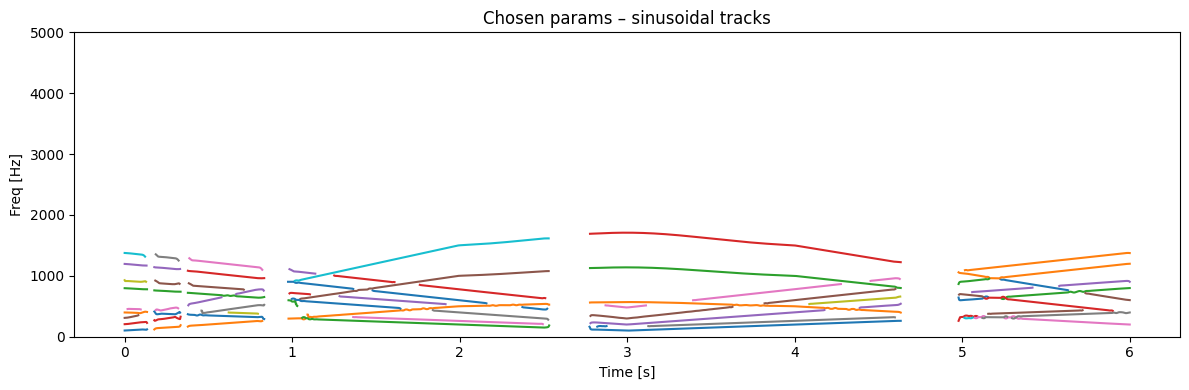

In [ ]:
import itertools

def run_params(window, M, N, t, maxnSines, minSineDur, fOff, fSlope):
    w = get_window(window, M)
    tf, tm, tp = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, fOff, fSlope)
    y_ = SM.sineModelSynth(tf, tm, tp, Ns, H, fs)
    return tf, tm, tp, y_, snr_db(x, y_)

fs, x = _safe_wavread(input_file)

H = 128
Ns = 512

win = 'blackmanharris'
M_list = [3071, 4095, 6143]
N_list = [4096, 8192, 12288]  
t_list = [-70.0, -75.0, -80.0]
maxS_list = [24, 30, 36]
minDur_list = [0.05, 0.08]
fOff_list = [30, 40, 50]
fSlope_list = [0.0015, 0.0020, 0.0025]

best = None
best_pack = None

for M_, N_, t_, maxS_, minD_, fO_, fS_ in itertools.product(M_list, N_list, t_list, maxS_list, minDur_list, fOff_list, fSlope_list):
    if N_ < M_:
        continue
    try:
        tf, tm, tp, y_, snr = run_params(win, M_, N_, t_, maxS_, minD_, fO_, fS_)
        key = (snr, M_, N_, t_, maxS_, minD_, fO_, fS_)
        if (best is None) or (snr > best):
            best = snr
            best_pack = (tf, tm, tp, y_, key)
    except Exception as e:
        pass

tf_b, tm_b, tp_b, y_b, key = best_pack
snr_b, M_b, N_b, t_b, maxS_b, minD_b, fO_b, fS_b = key
print("Best SNR (db ):", snr_b)
print("params:", {"window": win, "M": M_b, "N": N_b, "t": t_b, "maxnSines": maxS_b, "minSineDur": minD_b, "freqDevOffset": fO_b, "freqDevSlope": fS_b})

plt.figure(figsize=(12,4))
numFrames = tf_b.shape[0]
frmTime = H*np.arange(numFrames)/float(fs)
tf_plot = tf_b.copy()
tf_plot[tf_plot<=0] = np.nan
plt.plot(frmTime, tf_plot)
plt.title(" params: sinusoidal tracks"); plt.xlabel("Time [s]"); plt.ylabel("Freq hz"); plt.ylim(0, 5000); plt.tight_layout(); plt.show()

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y_b, rate=fs))

**Question  E5 - 4.2:**

#### Explain the results of Part 4
------

# ==== ANSWER FOR Q 4.2 =====

So we analyze an audio with sharp onsets, different amplitudes, closed space frequencies and chirps that cross over time.

Two tests: 
1. Fixed parameter test
2. Parameter-search test

Observations:
-Shorter windows follow transients better
-Longer windows improved spectral clarity but with downside on attacks (blurred)
-With small freqDevOffSet or freqDevSlope tracks broke 
-Thresholds can end up with weak components lost (-60db), too low may have false peaks and noise (-90db) and around -70 and -75 seem to be the most conservative decision


We can notice that time frequency trade off and window/tracking parameters are important for the sinusoidal modeling 


In conclusion, the analysis produces a reconstructed sound that's slightly precise.
So, we can infer: window choice determines if weak and strong components can work together without noise or interference; window length controls trade off of temporal and frequency accuracy
Sinusoidal modeling can represent dynamic and dense sounds accurately, with the right parameters 


# ==== END OF ANSWER FOR Q 4.2 =====

